In [47]:
pd.set_option('display.float_format', str)

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [49]:
# Import all files here.
patients_file = "https://github.com/spiros/nkua-health-data-science/raw/master/data/dest/patients.csv.gz"
cond_file = "https://github.com/spiros/nkua-health-data-science/raw/master/data/dest/conditions.csv.gz"
obs_file = "https://github.com/spiros/nkua-health-data-science/raw/master/data/dest/observations.csv.gz"
loinc_file = "https://github.com/spiros/nkua-health-data-science/raw/master/data/dest/dictionary_loinc.csv"

df_patients = pd.read_csv(patients_file)
df_cond = pd.read_csv(cond_file)
df_obs = pd.read_csv(obs_file)
df_loinc = pd.read_csv(loinc_file)

In [50]:
# Drop columns that are not required
c_to_drop = [
    'SSN',
    'DRIVERS',
    'PASSPORT',
    'PREFIX',
    'FIRST',
    'LAST',
    'SUFFIX',
    'MAIDEN',
    'MARITAL',
    'BIRTHPLACE',
    'ADDRESS',
    'CITY',
    'STATE',
    'COUNTY',
    'ZIP',
    'LAT',
    'LON',
    'HEALTHCARE_EXPENSES',
    'HEALTHCARE_COVERAGE'
]

df_patients.drop(columns=c_to_drop, inplace=True)

# The date of birth and the date of death should be a datetime
# Convert the BIRTHDATE column to a datetime column. If you try to convert the 
# column directly, an error will occur as some values are not valid dates.
# Adding the "errors=coerce" will convert any invalid dates e.g. malformed, strings, numbers etc
# into missing values
df_patients['BIRTHDATE'] = pd.to_datetime(
    df_patients['BIRTHDATE'],
    errors='coerce'
)

df_patients['DEATHDATE'] = pd.to_datetime(
    df_patients['DEATHDATE'],
    errors='coerce'
)

# Create a flag for patient exclusion called 'exclude' and set default value to 0
df_patients['exclude'] = 0

# Exclude patients with invalid or missing gender
valid_genders = ['F', 'M']
m = (df_patients.GENDER.isna())|(~df_patients.GENDER.isin(valid_genders))
df_patients.loc[m, 'exclude'] = 1

# Exclude patients with invalid RACE values
valid_race = ['white', 'black', 'asian', 'hawaiian', 'other', 'native']
m = (df_patients.RACE.isna())|(~df_patients.RACE.isin(valid_race))
df_patients.loc[m, 'exclude'] = 1

# Display and exclude patients with an invalid date of birth
# Date of birth is missing
m = (df_patients.BIRTHDATE.isna())
df_patients.loc[m, 'exclude'] = 1

# Find and exclude patients were the date of birth is after the date of death
m = df_patients['BIRTHDATE']>df_patients['DEATHDATE']
df_patients.loc[m, 'exclude'] = 1 

m = (df_patients.BIRTHDATE.dt.year < 1910)|(df_patients.BIRTHDATE.dt.year > 2021)
df_patients.loc[m, 'exclude'] = 1

df_patients.drop(df_patients[df_patients['exclude']==1].index, inplace=True)
df_patients.reset_index(inplace=True, drop=True)

In [60]:
df_cond.sort_values(['PATIENT', 'START'], inplace=True)
df_ht = df_cond[df_cond['CODE']==59621000].groupby('PATIENT').first().reset_index()
df_ht.drop(columns=['STOP', 'ENCOUNTER', 'CODE'], inplace=True)

df_patients_ht = df_patients.merge(
    df_ht,
    how='left',
    left_on='Id',
    right_on='PATIENT'
)

df_patients_ht.drop(columns=['PATIENT'], inplace=True)

df_blood_pressures = df_obs[df_obs['CODE'].isin(['8480-6', '8462-4'])].copy()
df_blood_pressures['VALUE'] = df_blood_pressures['VALUE'].astype(float)

m = (df_blood_pressures['CODE']=='8480-6')&(df_blood_pressures['VALUE']>220)
df_blood_pressures.drop(df_blood_pressures[m].index, inplace=True)
m = (df_blood_pressures['CODE']=='8462-4')&(df_blood_pressures['VALUE']<30)
df_blood_pressures.drop(df_blood_pressures[m].index, inplace=True)

df_patients_ht_bp = df_patients_ht.merge(
    df_blood_pressures, 
    how='left',
    left_on='Id', 
    right_on='PATIENT')

df_patients_ht_bp['hypertension'] = df_patients_ht_bp.apply(lambda x: 1 if pd.notna(x.START) else 0, axis=1)

In [76]:
m = (df_patients_ht_bp['hypertension']==1)&(df_patients_ht_bp['DATE']<df_patients_ht_bp['START'])
df_patients_ht_bp.drop(df_patients[m].index, inplace=True)
df_patients_ht_bp.reset_index(drop=True, inplace=True)

/var/folders/9h/mwn512z94f7_8k0w2xq2z02h0000gn/T/ipykernel_9891/899069428.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_patients_ht_bp.drop(df_patients[m].index, inplace=True)


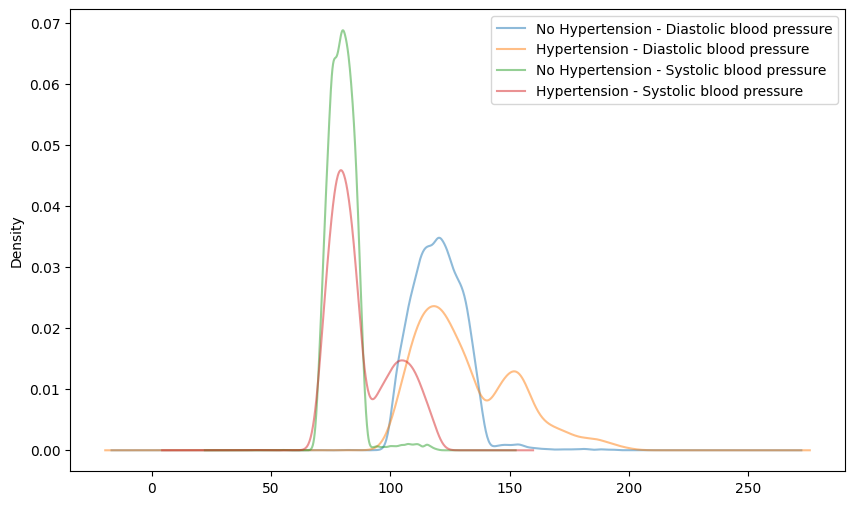

In [106]:
labs_lkp = {
    '8480-6': 'Diastolic blood pressure',
    '8462-4': 'Systolic blood pressure'
}
status_lkp = {
    0: 'No Hypertension', 
    1: 'Hypertension'
}
plt.figure(figsize=(10, 6))
for loinc, labtype in labs_lkp.items():
    for status, group in df_patients_ht_bp[df_patients_ht_bp['CODE']==loinc].groupby('hypertension'):
        label = f"{status_lkp[status]} - {labs_lkp[loinc]}"
        group['VALUE'].astype('float').plot(kind='kde', alpha=0.5, label=label, stacked=True)
plt.legend()

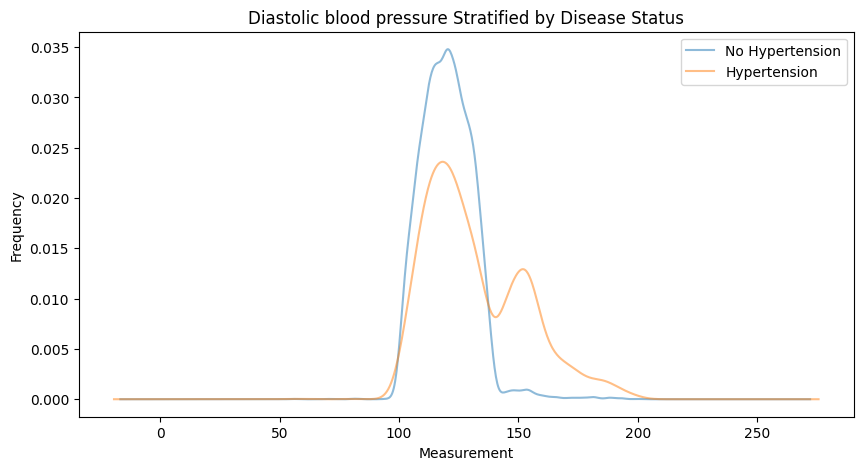

In [98]:
plt.figure(figsize=(10, 5))

dx_code = '8480-6'
for status, group in df_patients_ht_bp[df_patients_ht_bp['CODE']==dx_code].groupby('hypertension'):
    label = f"{status_lkp[status]}"
    group['VALUE'].astype('float').plot(kind='kde', alpha=0.5, label=label, stacked=True)

plt.legend()
plt.title('Diastolic blood pressure Stratified by Disease Status')
plt.xlabel('Measurement')  # or another relevant label for the x-axis
plt.ylabel('Frequency')
plt.show()

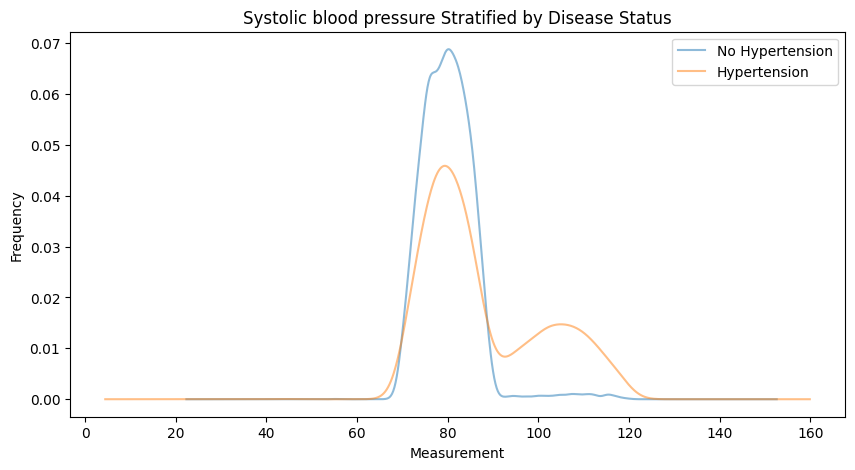

In [95]:
plt.figure(figsize=(10, 5))

dx_code = '8462-4'
for status, group in df_patients_ht_bp[df_patients_ht_bp['CODE']==dx_code].groupby('hypertension'):
    label = f"{status_lkp[status]}"
    group['VALUE'].astype('float').plot(kind='kde', alpha=0.5, label=label, stacked=True)

plt.legend()
plt.title('Systolic blood pressure Stratified by Disease Status')
plt.xlabel('Measurement')  # or another relevant label for the x-axis
plt.ylabel('Frequency')
plt.show()


[Text(0.5, 1.0, 'Systolic blood pressure')]

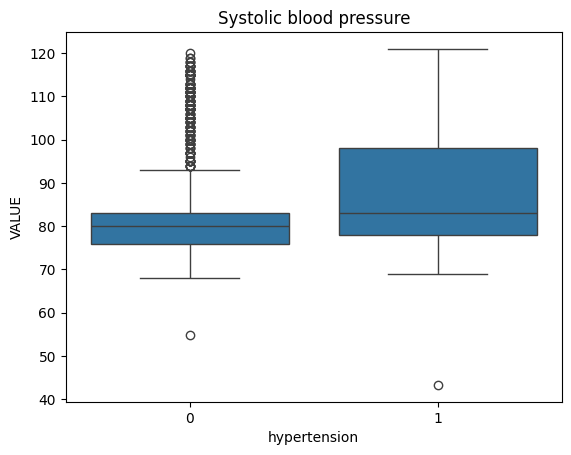

In [127]:
sns.boxplot(
    data=df_patients_ht_bp[df_patients_ht_bp['CODE']=='8462-4'],
    x='hypertension', 
    y='VALUE',
).set(title="Systolic blood pressure")

[Text(0.5, 1.0, 'Diastolic blood pressure')]

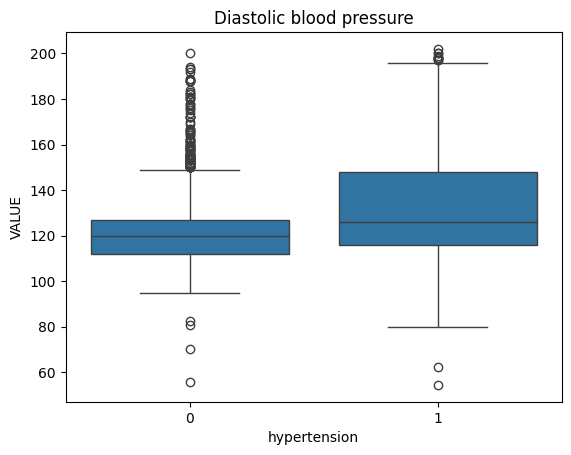

In [129]:
sns.boxplot(
    data=df_patients_ht_bp[df_patients_ht_bp['CODE']=='8480-6'],
    x='hypertension', 
    y='VALUE',
).set(title="Diastolic blood pressure")

[Text(0.5, 1.0, 'Diastolic blood pressure')]

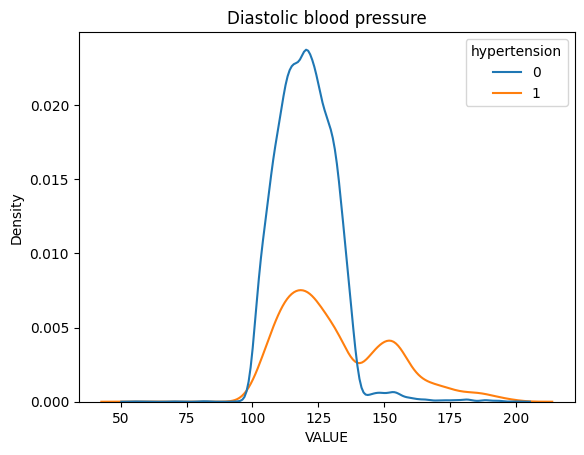

In [136]:
sns.kdeplot(
    data=df_patients_ht_bp[df_patients_ht_bp['CODE']=='8480-6'],
    x='VALUE',
    hue='hypertension',
    common_norm=True).set(title="Diastolic blood pressure")

[Text(0.5, 1.0, 'Systolic blood pressure')]

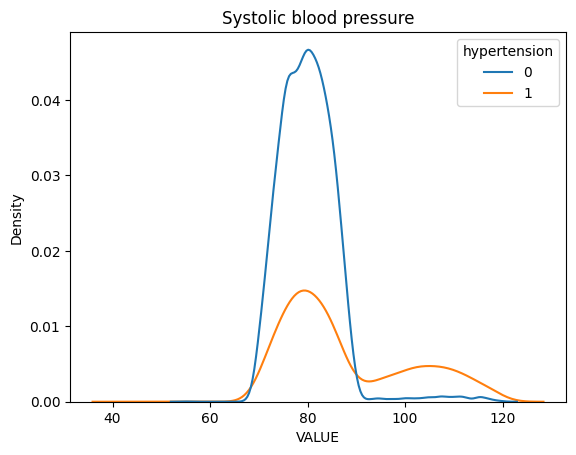

In [154]:
sns.kdeplot(
    data=df_patients_ht_bp[df_patients_ht_bp['CODE']=='8462-4'],
    x='VALUE',
    hue='hypertension',
    common_norm=True).set(title="Systolic blood pressure")

In [152]:
t_statistic, p_value = stats.ttest_ind(
    df_patients_ht_bp[(df_patients_ht_bp['CODE']=='8480-6')&(df_patients_ht_bp['hypertension']==1)].VALUE.values,
    df_patients_ht_bp[(df_patients_ht_bp['CODE']=='8480-6')&(df_patients_ht_bp['hypertension']==0)].VALUE.values
)
print('T-test Statistics=%.3f, p=%.3f' % (t_statistic, p_value))

stat, p = stats.mannwhitneyu(
    df_patients_ht_bp[(df_patients_ht_bp['CODE']=='8480-6')&(df_patients_ht_bp['hypertension']==1)].VALUE.values,
    df_patients_ht_bp[(df_patients_ht_bp['CODE']=='8480-6')&(df_patients_ht_bp['hypertension']==0)].VALUE.values
)

print('Mann–Whitney U Statistics=%.3f, p=%.3f' % (stat, p))

T-test Statistics=42.145, p=0.000
Mann–Whitney U Statistics=24909938.000, p=0.000


In [153]:
t_statistic, p_value = stats.ttest_ind(
    df_patients_ht_bp[(df_patients_ht_bp['CODE']=='8462-4')&(df_patients_ht_bp['hypertension']==1)].VALUE.values,
    df_patients_ht_bp[(df_patients_ht_bp['CODE']=='8462-4')&(df_patients_ht_bp['hypertension']==0)].VALUE.values
)

print('T-test Statistics=%.3f, p=%.3f' % (t_statistic, p_value))

stat, p = stats.mannwhitneyu(
    df_patients_ht_bp[(df_patients_ht_bp['CODE']=='8462-4')&(df_patients_ht_bp['hypertension']==1)].VALUE.values,
    df_patients_ht_bp[(df_patients_ht_bp['CODE']=='8462-4')&(df_patients_ht_bp['hypertension']==0)].VALUE.values
)

print('Mann–Whitney U Statistics=%.3f, p=%.3f' % (stat, p))

T-test Statistics=45.535, p=0.000
Mann–Whitney U Statistics=25234329.500, p=0.000
